# Differential cross section

In [1]:
show_fig = True
save_fig = True

In [8]:
# %load "../../style.py"
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit

sns.set(style='ticks', palette='Set2') 
sns.despine()

# These are the colors. Notice how this is programmed:
# You initialize your colors by 
# colorset = palette()
# then you can cycle through the colors:
# color = next(colorset)
# if you want your set to be reset, just create
# a new palette() instance! This way the colors do not interfere.

color_names = ['windows blue', "pale red", "faded green", "amber", 
          'dark green', 'dark fuchsia', 'browny orange', 
          'puke green', 'dark royal blue', 'dusty purple', 'red orange']
colors = sns.xkcd_palette(color_names)
palette = lambda: itertools.cycle(sns.xkcd_palette(color_names) )

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['legend.markerscale'] = 4
rcParams['axes.titlesize'] = fontsize_labels
rcParams['text.color'] = "0.3"
rcParams['xtick.color'] = "0.3"
rcParams['ytick.color'] = "0.3"
rcParams['axes.labelcolor'] = "0.3"
rcParams['axes.edgecolor'] = "0.8"

xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  

if not save_fig:
        rcParams['figure.figsize'] = (13, 8) 
fig_dir = "./figures/"  # directory of figures

def fixticks(ax):    
    for t in ax.xaxis.get_ticklines(): t.set_color('0.8')
    for t in ax.yaxis.get_ticklines(): t.set_color('0.8')


In [3]:
# %load ../../tools.py
def uc_str(c, max_digit=4):
    """
    input format: uc.ufloat
    rounds float and corrisponding error to last significant digit
    returns float and error as string
    as integers with max max_digit (=4) error digits
    as floats with max 4 error digits
    as exp else
    """
    digit = -int(np.floor(np.log10(c.s)))    
    if (c.s * 10**digit) < 1.5: # convention...
        digit += 1
    c_r = round(c.n, digit)
    s_c_r = round(c.s, digit)
    if (-3 < digit) * (digit <= 0): # returns readable integers
        c_str = '%i \pm %i'%(c_r, s_c_r)
    elif (0 < digit) * (digit < (max_digit + 1)): # returns readable floats (max 3 digits)
        c_str = ('%.' + str(digit) + 'f \pm %.' + str(digit) + 'f')%(c_r, s_c_r)
    else: # returns exp
        c_str = ('(%.1f \pm %.1f)\mathrm{e}%i')%(c_r * 10**(digit-1), s_c_r * 10**(digit-1), -(digit-1))
    return c_str

def enum(arr1, *args):
    i_range = range(len(arr1))
    return zip(i_range, arr1 ,*args)


def ucarray(X):
    return un.uarray([i.n for i in X],[i.s for i in X])

In [4]:
# %load ../../preamb.py
import numpy as np
import uncertainties as uc
import uncertainties.unumpy as un
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter as sav
from scipy.special import erfc
from scipy.integrate import quad
import sys
import re

npy_dir = "./data_npy/"
data_dir = "./data/"


In [5]:
nom = un.nominal_values
sam = un.std_devs
def gauss0(x, *p):
    A, mu, sigma = p
    return  A / (np.sqrt((2 * np.pi)) * sigma) * np.exp(-(x - mu)**2 / (2. * sigma**2))

def gauss1(x, *p):
    A, mu, sigma = p
    return  A  * np.exp(-(x - mu)**2 / (2. * sigma**2))

from scipy.constants import m_e, c, eV
na_cal = np.load(npy_dir + 'na_calibration.npy')

In [6]:
def rebin(y):
    # Rebinning: 1/16 of number of bins
    z = y[:-13] # last 13 bins are dropped to obtain a len(z) as a multiple of 16
    z = z.reshape([len(z) / 16, 16])
    z = np.sum(z, axis=1)
    return z

def linear(x, a, b):
    return (a*x + b)

def get_rates(file_name):
    # get data
    file_in = npy_dir + file_name + '.npy'
    y = np.load(file_in)
    y_e = un.uarray(y, np.maximum(1, np.sqrt(y)))      
    # get time
    file_in_mcd = data_dir + file_name + '.TKA'
    f = open(file_in_mcd)
    settings = f.read()
    f.close()
    lines = settings.split('\n')
    t = np.float(lines[1])   # livetime is written in line 1...
    print('measurement time in h: ', t/3600)
    y_e = y_e / t      # counts to rates
    return  y_e
#### Background ####
file_name = "coin_na_background"
y_bg_e = get_rates(file_name)
y_bg_e = rebin(y_bg_e)      # Rebinning: 1/16 of number of bins
y_bg = nom(y_bg_e)          # nominal values
y_bg_fil = sav(y_bg, 201, 7)# filtered
x_bg = np.arange(len(y_bg)) # channel

measurement time in h:  62.000277777777775


## Integration

Photon intensities at different angles. 
Integration is done numerically: sum over entries of histogram, 
multiplied by width of bin in energy domain (result of calibration_na). 
The differential cross section is approximated by the fraction of 
photons scattered at angle $\theta$ ($I(\theta)$) over the total incident 
intensity ($I_{tot}$), divided by the solid angle $\Delta \Omega$.

In [11]:
def plot_total():
    '''
    Plots total incident photons at NaI scintillator
    (source: 137Cs, no target in between)
    '''    
    #### GET DATA  ####
    file_name = "na_total_incident"
    y_e = get_rates(file_name)
    y_e = rebin(y_e)        # Rebinning: 1/16 of number of bins
    y_e = y_e - y_bg_e    # minus background (already rebinned)
    #y_e = y_e - y_rnd_e    # minus random coincidences (already rebinned)
    y_e[nom(y_e) < 0] = uc.ufloat(0, min(sam(y_e)[sam(y_e)>0])) # errors != 0 
    y = nom(y_e)            # nominal values
    y_fil = sav(y, 201, 7)  # filtered
    x = np.arange(len(y_e)) # channels
    
    x_min, x_max = (0,1023)
    mask = (x >x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    p0 = (600,600,25)
    coeff, cov = curve_fit(gauss0, x_fit, y_fit, p0=p0,
                sigma=y_sigma, absolute_sigma=True)
    
    #coeff, cov = curve_fit(gauss0, x_fit, y_fit, p0=p0)

        
    fit_peak = gauss0(x_fit, *coeff)

    c = uc.correlated_values(coeff, cov)

    ###### PLOTTING #################
    if show_fig:
        fig1, ax1 = plt.subplots(1, 1)
        fixticks(ax1)
        if not save_fig:
            #fig1.suptitle("NaI scintillator, total incident photons")
            pass
        ax1.plot(nom(linear(16 * x, *na_cal)), y, '.', alpha=0.5, label='data', color= colors[-1])
        #ax1.plot(nom(linear(16 * x_fit, *na_cal)), fit_peak, '-', alpha=0.7, label='data', linewidth = 5)
        ax1.set_xlabel("Energy / keV")
        ax1.set_ylabel("Rate / $s^{-1}$")
        ax1.set_xlim(0, 1100)
        ax1.set_ylim(0,)
        #ax1.legend(loc=1)
        ax1.grid(True)
        if save_fig:
            fig1.savefig(fig_dir + file_name + ".pdf")
            fig1.savefig(fig_dir + file_name + ".png")

    return(c[0])


measurement time in h:  1.006388888888889


/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


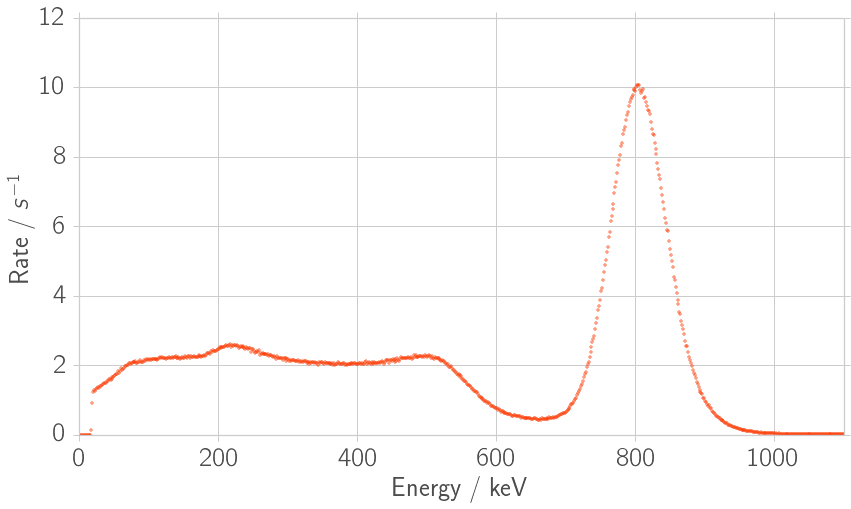

In [12]:
I_max = plot_total()

In [27]:
save_fig

True

In [10]:
theta_na = [15, 30, 45, 60, 75, 90, 105]
amplitude = []
for theta in theta_na:
    amplitude+= [uc.ufloat(0,0) + np.load(npy_dir + 'i_photon_' + str(theta) + '.npy')]
I = ucarray(amplitude)

/usr/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


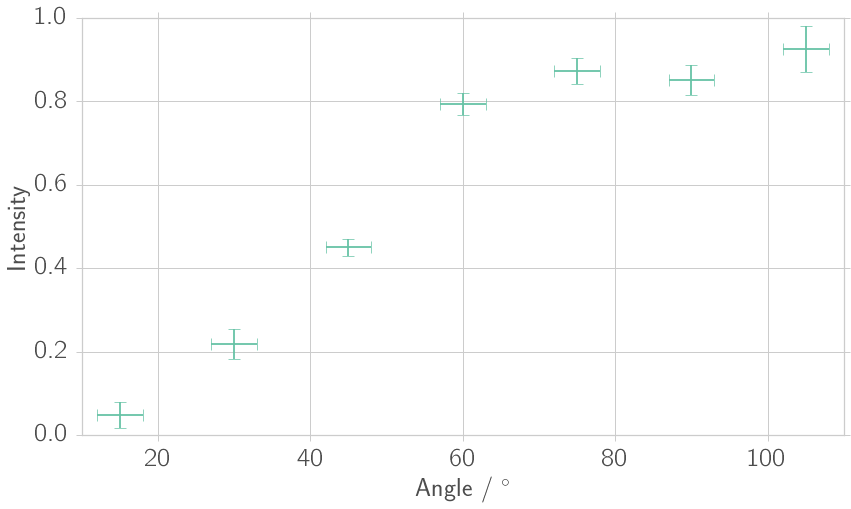

In [13]:
# Plotting

angle_error = 3
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle("Unmodified Intensities $I(\\theta)$")
ax1.errorbar(theta_na, nom(I), yerr=sam(I),xerr = angle_error,\
             fmt=",", alpha=0.9,elinewidth=2.0, capsize=6.2, capthick=0.8)

#ax1.plot(theta_fit,klein_nishina)
ax1.set_xlabel("Angle / ^\circ")
ax1.set_ylabel("Intensity")
ax1.set_xlim(10,110)
ax1.grid(True)
if show_fig:
    fig1.show()
if save_fig:
    file_name = "na_intensities"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


dE can be calculated with the scaling of the calibration => 1 Channel equals to a certain amount of energy. We furthermore have to bear in mind that we chose only every 16th bin in the distribution.

In [12]:
epsilon = un.uarray([0.41,0.45,0.51,0.55,0.63,0.65,0.70],[0.2]*7)
epsilon_0 = uc.ufloat(0.40,0.01)
mu = un.uarray([0.091,0.091,0.098,0.108,0.120,0.120,0.120],[0.1]*7)
mu_0 = uc.ufloat(0.089,0.01)
d = uc.ufloat(1.45,0.1)
n_e = uc.ufloat(3.4,0.1)
u = uc.ufloat(4.7,0.1)
U = uc.ufloat(11.5,0.5)
D_omega = u**2  / U**2 * np.pi

In [15]:
uc_str(u**2  / U**2)

'0.17 \\pm 0.02'

In [16]:
cross_section = (I / I_max)  * (epsilon_0 / epsilon) / (n_e * d * D_omega )/ \
((1 - un.exp(- mu * d/2)) * un.exp(- mu_0 * d/2) )*10**4

/usr/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


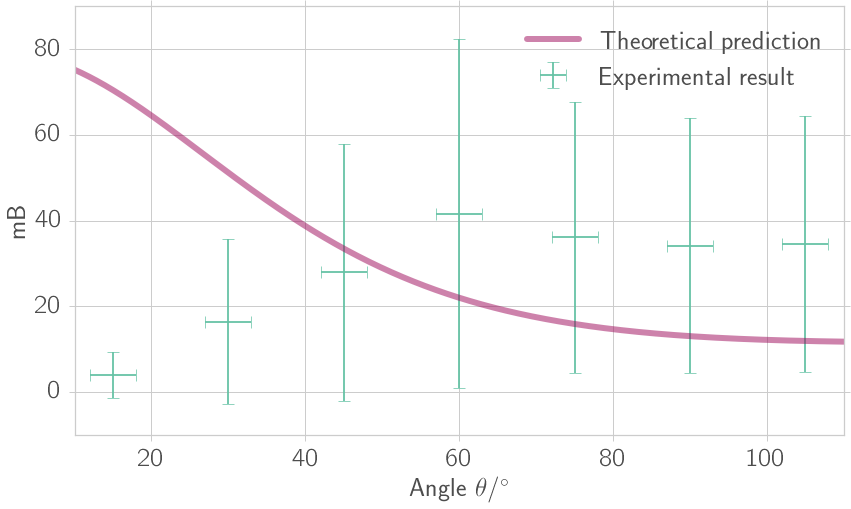

In [17]:
theta_fit = np.linspace(0,120,1000)
E_p = 662
from scipy.constants import physical_constants as pc

def E_red(E_gamma):
    # Energy in units of electron mass energy equivalent
    m_e = pc["electron mass energy equivalent in MeV"][0] * 10**3 # in keV
    return(E_gamma / m_e)
def dsdo(E_gamma, theta_deg):
    #Klein-Nishina differential cross section
    theta = theta_deg * np.pi / 180
    alpha = pc["fine-structure constant"][0] # fine struc. const.
    lamb_C = pc["Compton wavelength"][0] # Compton wavelength in m
    rho = 1 + E_red(E_gamma) * (1 - np.cos(theta)) # = E_gamma / E_photon
    A = (alpha * lamb_C / np.pi)**2 / 8 * 10**31 # in mb
    return A / rho**2 * (rho + 1 / rho - np.sin(theta)**2)

# Plotting
angle_error = 3
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle("Cross section")
ax1.errorbar(theta_na, nom(cross_section), yerr=sam(cross_section),xerr = angle_error,\
             fmt=",", alpha=0.9,elinewidth=2.0, capsize=6.2, capthick=0.8, label= "Experimental result")

ax1.plot(theta_fit, dsdo(E_p, theta_fit),linewidth = 6, label = "Theoretical prediction", color = colors[5],alpha = 0.5)
ax1.set_xlabel("Angle $\\theta / ^\circ$")
ax1.set_ylabel("mB")
ax1.set_xlim(10,110)
ax1.grid(True)
ax1.legend(loc = 1)
if show_fig:
    fig1.show()
if save_fig:
    file_name = "na_cross_section"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")

## Approach II: Summation of all rates

In [33]:
# Total incident radiation
file_name = "na_total_incident"
y_e = get_rates(file_name)
y_e = rebin(y_e)        # Rebinning: 1/16 of number of bins
y_e = y_e - y_bg_e    # minus background (already rebinned)
#y_e = y_e - y_rnd_e    # minus random coincidences (already rebinned)
y_e[nom(y_e) < 0] = uc.ufloat(0, min(sam(y_e)[sam(y_e)>0])) # errors != 0 
y_total_e = y_e
y_total = nom(y_e)            # nominal values

x = np.arange(len(y_e)) # channels
x_min, x_max = [130, 1000]
sum_mask = (x_min < x) * (x < x_max) # throw away values below channel 150
I_total = np.sum(y_total_e)

theta_na = [0, 15, 30, 45, 60, 75, 90, 105, 120] # data for 0 is not usable...
#theta_na = [15] # data for 0 is not usable...
sums = []
for theta in theta_na:
    #### GET DATA  ####
    file_name = "coin_na_" + str(theta)
    y_e = get_rates(file_name)
    y_e = rebin(y_e)        # Rebinning: 1/16 of number of bins
    y_e = y_e - y_bg_e    # minus background (already rebinned)
    if theta==0:
        #### Random coincidences ####
        file_name = "coin_na_random"
        y_rnd_e = get_rates(file_name)
        y_rnd_e = rebin(y_rnd_e)      # Rebinning: 1/16 of number of bins
        y_rnd = nom(y_rnd_e)          # nominal values
        y_rnd_fil = sav(y_rnd, 201, 7)# filtered
        y_e = y_e - y_rnd_e    # minus random coincidences (already rebinned)
    y_e[nom(y_e) < 0] = uc.ufloat(0,min(sam(y_e)[sam(y_e)>0]))
    # set values smaller zero to zero. NOT A GOOD IDEA! ERROR IS ZERO THEN! DIRTY HARRY HACK
    y = nom(y_e)            # nominal values
    #### Sum
    sums.append(np.sum(y_e[sum_mask]))

measurement time in h:  1.006388888888889
measurement time in h:  0.5
measurement time in h:  1.0
measurement time in h:  0.5
measurement time in h:  0.5
measurement time in h:  1.0
measurement time in h:  1.0
measurement time in h:  1.0
measurement time in h:  1.0
measurement time in h:  0.5
measurement time in h:  0.5


In [34]:
epsilon = un.uarray([0.40, 0.41,0.45,0.51,0.55,0.63,0.65,0.70,0.75],[0.01]*9)
epsilon_0 = uc.ufloat(0.40,0.01)
mu = un.uarray([0.43,0.091,0.091,0.098,0.108,0.120,0.120,0.120, 0.126],[0.001]*9) # absorption 1 / cm
mu_0 = uc.ufloat(0.089,0.01)
d = uc.ufloat(1.45,0.1) # cm
n_e = uc.ufloat(3.4,0.1)
u = uc.ufloat(4.7,0.1)
U = uc.ufloat(11.5,0.5)
D_omega = u**2  / U**2 * np.pi

theta_na = np.array([0, 15, 30, 45, 60, 75, 90, 105, 120]) # data for 0 is not usable...
d = un.uarray(1.45 / np.cos(np.radians(theta_na) / 2), 0.1) # cm, corrected for angles

I = np.array(sums)
cross_section = (I / I_total)  * (epsilon_0 / epsilon) / (n_e * d * D_omega )/ \
((1 - un.exp(- mu * d/2)) * un.exp(- mu_0 * d/2) )*10**4


/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


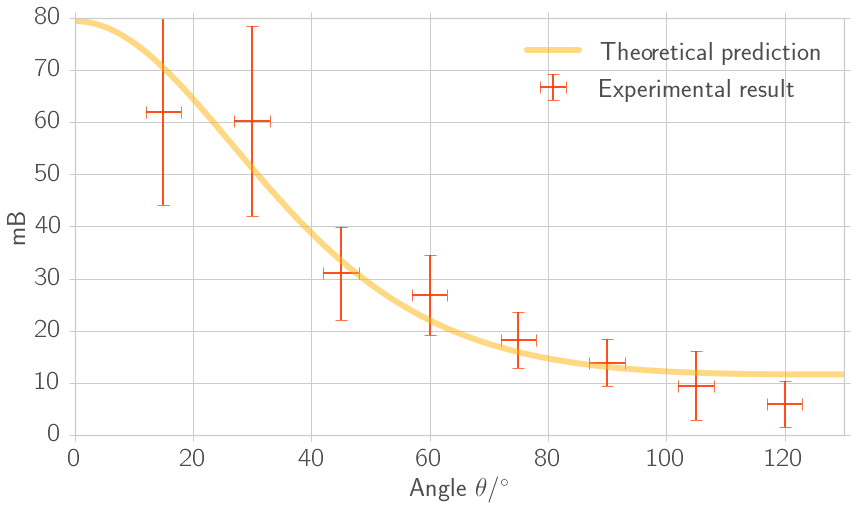

In [47]:
theta_fit = np.linspace(0, 130, 1000)
E_p = 662
from scipy.constants import physical_constants as pc

def E_red(E_gamma):
    # Energy in units of electron mass energy equivalent
    m_e = pc["electron mass energy equivalent in MeV"][0] * 10**3 # in keV
    return(E_gamma / m_e)
def dsdo(E_gamma, theta_deg):
    #Klein-Nishina differential cross section
    theta = theta_deg * np.pi / 180
    alpha = pc["fine-structure constant"][0] # fine struc. const.
    lamb_C = pc["Compton wavelength"][0] # Compton wavelength in m
    rho = 1 + E_red(E_gamma) * (1 - np.cos(theta)) # = E_gamma / E_photon
    A = (alpha * lamb_C / np.pi)**2 / 8 * 10**31 # in mb
    return A / rho**2 * (rho + 1 / rho - np.sin(theta)**2)

# Plotting
angle_error = 3
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle("Cross section")
ax1.errorbar(theta_na[1::], nom(cross_section)[1::], yerr=sam(cross_section)[1::],xerr = angle_error,\
             fmt=",", alpha=0.9,elinewidth=2.0, capsize=6.2, capthick=0.8, label= "Experimental result", color=colors[-1])

ax1.plot(theta_fit, dsdo(E_p, theta_fit),linewidth = 6, label = "Theoretical prediction", color = colors[3],alpha = 0.5)
ax1.set_xlabel("Angle $\\theta / ^\circ$")
ax1.set_ylabel("mB")
ax1.set_xlim(0,130)
ax1.grid(True)
ax1.legend(loc = 1)

if save_fig:
    file_name = "na_cross_section"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")